In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-10-04

Goals: 
1. Analyze simulated data with DRW and DRW+periodic
1.1. Degrade simulated data to observable cadence
1.2 Establish sensitivity limits
2. Analyze real data with DRW and DRW+periodic

Each Section can/should be able to run independently,
only these initial imports should be shared among all sections

"""
import numpy as np
import pandas as pd
import time

from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper



# Init analysis of simulated data

In [2]:
# generated in create_data script, to avoid epyc failure
t_multi = np.load('/astro/users/ncaplar/data/t_multi.npy')
y_multi = np.load('/astro/users/ncaplar/data/y_multi.npy')
yerr_multi = np.load('/astro/users/ncaplar/data/yerr_multi.npy')

In [5]:

id, t, y, yerr, filter = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

for i in range(100):
    # data = data_all[()].get(i)

    # get time for a single lightcurve
    t_true = t_multi[i]
    # sample 100 points from 200
    downsample_int = np.sort(np.random.choice(np.arange(len(t_true)), 100))
    # extract 100 times from 200
    t_single = t_true[downsample_int]

    id = np.append(id, np.full(len(downsample_int), i))
    filter_single = np.full(len(t_single), 'r')
    t = np.append(t, t_single)
    filter = np.append(filter, filter_single)

    # create custom errors
    y_err_single = np.full(len(t_single), 0.001)
    yerr = np.append(yerr, np.full(len(t_single), 0.001))

    # extract measurements; 100 from each lightcurve
    # y_pre = data['y_tot'][downsample_int]
    y_pre = y_multi[i][downsample_int]

    # create noise and add to lightcurves
    noise = np.random.normal(0, y_err_single)
    y = np.append(y, y_pre + noise)

# columns assigned manually
manual_colmap = ColumnMapper().assign(
    id_col="id", time_col="t", flux_col="y", err_col="yerr", band_col="filter"
)

# ens = Ensemble(silence_logs='error')
ens = Ensemble()
ens.from_source_dict({'id': id, "t": t, 'y': y, 'yerr': yerr, 'filter': filter},
                        column_mapper=manual_colmap)
single_lc = ens.compute("source")[id == 0]
# comment out line below if trying to run ensamble.batch
# ens.client.close()
##########



/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33111 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45433
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:33111/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36501'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40385'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39963'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43357'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34079'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41804'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35388'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42303'


In [6]:
JaxPeriodDrwFit_instance = ch.JaxPeriodDrwFit()

In [7]:
ens.head("object", 5)

filter,nobs_r,nobs_total
id,,
0.0,100,100
1.0,100,100
2.0,100,100
3.0,100,100
4.0,100,100


In [8]:
ens.head("source", 5)

,t,y,yerr,filter
id,,,,
0.0,104.035404,-0.178309,0.001,r
0.0,110.606061,-0.114827,0.001,r
0.0,136.523652,-0.119349,0.001,r
0.0,148.569857,0.029500,0.001,r
0.0,150.760076,0.053097,0.001,r


In [9]:
# 20.6 second
res = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 't', 'y', 'yerr',
                 compute=True, meta=None, n_init=100)
print(res)

id
0.0     [-129.8543171310671, 2.2952704672830704, -0.77...
1.0     [-125.06774239793788, 2.2454832550376214, -0.6...
2.0     [-129.19153581396438, 2.0109551037342817, -0.8...
3.0     [-113.93138087222452, 1.664258493219286, -0.83...
4.0     [-124.25437066957599, 2.3919998011020134, -0.6...
                              ...                        
95.0    [-123.59434269083566, 2.2617468727321612, -0.7...
96.0    [-134.95465378350644, 1.7851771511631847, -0.8...
97.0    [-126.45339674303835, 2.0249693391299366, -0.7...
98.0    [-129.96935212915713, 1.5254637793727104, -0.9...
99.0    [-106.14477313607473, 2.0904558534035984, -0.6...
Name: id, Length: 100, dtype: object


In [10]:
ens.client.close()

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36501'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:40385'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39963'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43357'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:34079'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:41804'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0

# Redback - exploring degrading lightcurve to ZTF cadence

In [11]:
t = single_lc['t'].values
y = single_lc['y'].values
yerr = single_lc['yerr'].values

# This block shows that the code works on a single lightcurve
# And it is faster second time
t1 = time.time()
test_single_lc_res = JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init=100)
t2 = time.time()
print(f'Execution time for single lc is {t2 - t1} sec')
print('Best result is:' + str(test_single_lc_res))
t1 = time.time()
test_single_lc_res = JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init=100)
t2 = time.time()
print(f'Execution time for second run with single lc is {t2 - t1} sec')
print('Best result is:' + str(test_single_lc_res))

Execution time for single lc is 4.026710748672485 sec
Best result is:[-129.85431713    2.29527047   -0.77088343    1.42985345   -1.39499854]
Execution time for second run with single lc is 0.1607820987701416 sec
Best result is:[-129.85431713    2.29527047   -0.77088343    1.42985345   -1.39499854]


In [12]:
datadir = '/astro/users/ncaplar/github/redback/redback/tables'
pointings_database_name = 'ztf.tar.gz'

In [13]:
pointings_database = pd.read_csv(datadir + "/" + pointings_database_name, compression='gzip')

In [14]:
# 58288.17 = June-19-2018
# 59822.52 = August-31-2022
np.sort(pointings_database['expMJD'].values)

array([58288.17 , 58288.176, 58288.18 , ..., 59822.51 , 59822.516,
       59822.52 ])

In [15]:
pointings_database['_ra']

0         3.822735
1         4.436831
2         3.560472
3         3.355396
4         3.520526
            ...   
106643    1.984300
106644    2.114880
106645    2.039341
106646    2.114880
106647    0.923487
Name: _ra, Length: 106648, dtype: float64

In [26]:
survey_fov_sqdeg = 36
survey_fov_sqrad = survey_fov_sqdeg*(np.pi/180.0)**2
survey_radius = np.sqrt(survey_fov_sqrad/np.pi)
print('survey_radius:' + str(survey_radius))

def find_sky_overlaps(pointings_databasem, parameters):
    """
    Find the sky indices of the pointings database that overlap with the transient.
    """
    pointings_sky_pos = np.column_stack((pointings_database['_ra'].values, pointings_database['_dec'].values))
    transient_sky_pos = np.column_stack((parameters['ra'].values, parameters['dec'].values))

    transient_sky_pos_3D = np.vstack([np.cos(transient_sky_pos[:,0]) * np.cos(transient_sky_pos[:,1]),
                                        np.sin(transient_sky_pos[:,0]) * np.cos(transient_sky_pos[:,1]),
                                        np.sin(transient_sky_pos[:,1])]).T
    pointings_sky_pos_3D = np.vstack([np.cos(pointings_sky_pos[:, 0]) * np.cos(pointings_sky_pos[:,1]),
                                        np.sin(pointings_sky_pos[:,0]) * np.cos(pointings_sky_pos[:,1]),
                                        np.sin(pointings_sky_pos[:,1])]).T
    # law of cosines to compute 3D distance
    max_3D_dist = np.sqrt(2. - 2. * np.cos(survey_radius))
    survey_tree = KDTree(pointings_sky_pos_3D)
    overlap_indices = survey_tree.query_ball_point(x=transient_sky_pos_3D, r=max_3D_dist)

    return overlap_indices, transient_sky_pos_3D, pointings_sky_pos_3D

survey_radius:0.05908179503018386


In [27]:
np.sqrt(36/np.pi)/(np.pi*180)

0.005986237404172219

In [28]:
survey_fov_sqrad
survey_radius

0.05908179503018386

In [40]:
parameters = pd.DataFrame(np.array([[0, 1, 2], [0.2813573, 1, 2], [-0.0978646, 1, 2]]).T,
                   columns=['id', 'ra', 'dec'])

parameters_deg = parameters.copy()

parameters['ra'] = parameters_deg['ra'] * np.pi/180
parameters['dec'] = parameters_deg['dec'] * np.pi/180

In [41]:
parameters_deg

,id,ra,dec
0,0.0,0.281357,-0.097865
1,1.0,1.000000,1.000000
2,2.0,2.000000,2.000000


In [57]:
time_space_overlap, transient_sky_pos_3D, pointings_sky_pos_3D = find_sky_overlaps(pointings_database, parameters)

In [67]:
time_space_overlap

array([list([1197, 6218, 6747, 26673, 53966, 59013, 63142, 72220, 89371, 90141, 104257]),
       list([53966, 89371]),
       list([6440, 8696, 28612, 29057, 53966, 84899, 88721, 89371, 89849, 90726])],
      dtype=object)

In [58]:
transient_sky_pos_3D

array([[ 0.99998648,  0.00491058, -0.00170806],
       [ 0.99969541,  0.01744975,  0.01745241],
       [ 0.99878203,  0.03487824,  0.0348995 ]])

In [64]:
transient_sky_pos_3D

array([[ 0.99998648,  0.00491058, -0.00170806],
       [ 0.99969541,  0.01744975,  0.01745241],
       [ 0.99878203,  0.03487824,  0.0348995 ]])

In [66]:
pointings_sky_pos_3D

array([[-0.7744059 , -0.62769611,  0.07932904],
       [-0.2442343 , -0.8637784 ,  0.44072268],
       [-0.32216947, -0.14343914,  0.93575213],
       ...,
       [-0.42711299,  0.84386997,  0.32474292],
       [-0.4646512 ,  0.76802525,  0.44072268],
       [ 0.54983123,  0.72732088, -0.41071884]])

In [55]:
overlapping_database_iter = pointings_database.iloc[time_space_overlap[0]]

In [56]:
overlapping_database_iter

,expMJD,filter,fiveSigmaDepth,_ra,_dec
1197,58302.480,ztfi,20.223915,0.029788,-0.046251
6218,58364.293,ztfg,21.521942,6.251594,-0.046251
6747,58369.380,ztfr,21.425386,0.030956,-0.046251
26673,58697.438,ztfi,20.487064,0.029788,-0.046251
53966,59056.460,ztfr,21.695518,0.060614,0.016581
59013,59116.312,ztfr,21.050300,0.029788,-0.046251
63142,59156.223,ztfg,20.242613,6.250925,-0.046251
72220,59256.098,ztfr,19.394804,0.029788,-0.046251
89371,59483.340,ztfr,20.635460,0.060614,0.016581
90141,59491.316,ztfi,20.690083,0.029788,-0.046251


In [68]:
overlapping_database_iter

,expMJD,filter,fiveSigmaDepth,_ra,_dec
1197,58302.480,ztfi,20.223915,0.029788,-0.046251
6218,58364.293,ztfg,21.521942,6.251594,-0.046251
6747,58369.380,ztfr,21.425386,0.030956,-0.046251
26673,58697.438,ztfi,20.487064,0.029788,-0.046251
53966,59056.460,ztfr,21.695518,0.060614,0.016581
59013,59116.312,ztfr,21.050300,0.029788,-0.046251
63142,59156.223,ztfg,20.242613,6.250925,-0.046251
72220,59256.098,ztfr,19.394804,0.029788,-0.046251
89371,59483.340,ztfr,20.635460,0.060614,0.016581
90141,59491.316,ztfi,20.690083,0.029788,-0.046251


Text(0, 0.5, 'dec')

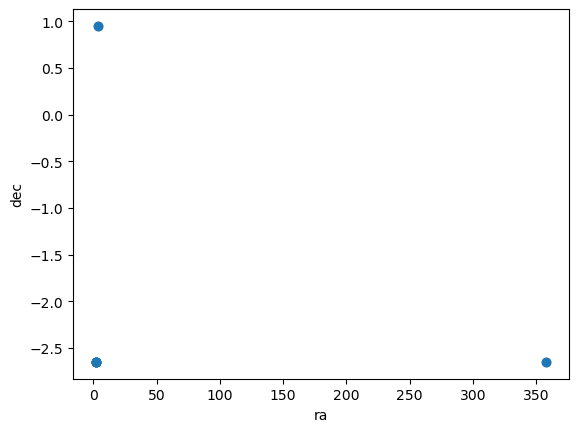

In [51]:
plt.scatter(overlapping_database_iter['_ra']*180/np.pi, overlapping_database_iter['_dec']*180/np.pi)
plt.xlabel('ra')
plt.ylabel('dec')

Text(0, 0.5, 'dec [deg]')

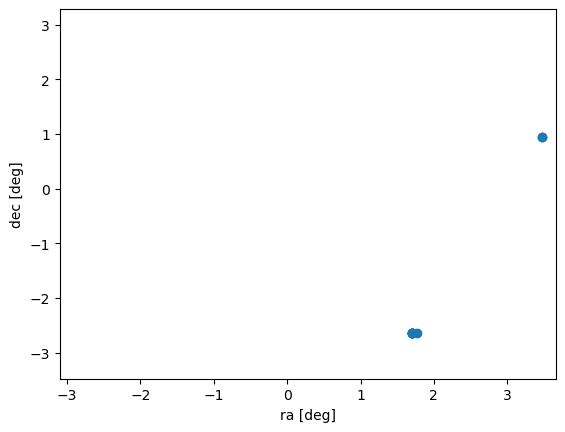

In [78]:
plt.scatter(pointings_database['_ra']*180/np.pi, pointings_database['_dec']*180/np.pi)
plt.xlim(0.2813573 - 3.38, 0.2813573 + 3.38)
plt.ylim(-0.097865 - 3.38, -0.097865 + 3.38)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')


In [84]:
a = (pointings_database['_ra']*180/np.pi < 3.38) 
b = (pointings_database['_ra']*180/np.pi > - 3.38) 
c = (pointings_database['_dec']*180/np.pi < 3.38) 
d = (pointings_database['_dec']*180/np.pi > - 3.38)

In [90]:
ab = np.logical_and(a, b)
cd = np.logical_and(c, d)
abcd = np.logical_and(ab, cd)
pointings_database[abcd]

,expMJD,filter,fiveSigmaDepth,_ra,_dec
1197,58302.480,ztfi,20.223915,0.029788,-0.046251
6747,58369.380,ztfr,21.425386,0.030956,-0.046251
26673,58697.438,ztfi,20.487064,0.029788,-0.046251
59013,59116.312,ztfr,21.050300,0.029788,-0.046251
72220,59256.098,ztfr,19.394804,0.029788,-0.046251
90141,59491.316,ztfi,20.690083,0.029788,-0.046251
104257,59789.418,ztfg,21.390000,0.029788,-0.046251


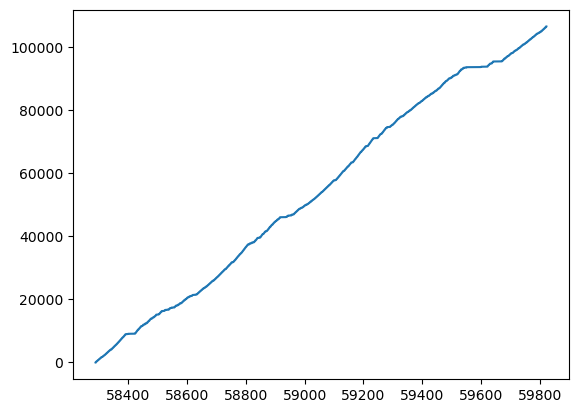

In [74]:
plt.plot(pointings_database['expMJD'],np.arange(len(pointings_database)))

In [89]:
survey_fov_sqdeg = 41253
survey_fov_sqrad = survey_fov_sqdeg*(np.pi/180.0)**2
survey_radius = np.sqrt(survey_fov_sqrad/np.pi)

In [100]:
int(np.min(pointings_database['expMJD']))

58288

In [103]:
# 30 sec exposure
exp_count_per_night=[]
for i in range(int(np.min(pointings_database['expMJD'])), int(np.max(pointings_database['expMJD']))):

    ab = np.logical_and(pointings_database['expMJD']>i, pointings_database['expMJD']<(i+1))
    exp_count_per_night.append(len(pointings_database[ab]))
    
exp_count_per_night = np.array(exp_count_per_night)

In [125]:
np.median(exp_count_per_night[exp_count_per_night>0])

92.0

(array([ 28.,  27.,  40.,  40.,  50., 181., 337., 187., 154., 122.]),
 array([  1. ,  14.9,  28.8,  42.7,  56.6,  70.5,  84.4,  98.3, 112.2,
        126.1, 140. ]),
 <BarContainer object of 10 artists>)

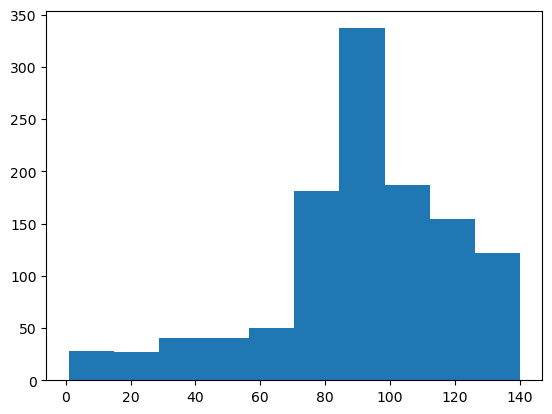

In [106]:
plt.hist(exp_count_per_night[exp_count_per_night>0])

In [109]:
int(np.min(pointings_database['expMJD']))
# Mar - 19 - 2022

58288

In [108]:
int(np.max(pointings_database['expMJD']))
# Aug - 31 - 2022

59822

In [112]:
a = (pointings_database['expMJD'] < 58289) 
b = (pointings_database['expMJD'] > 58288) 
pointings_database[np.logical_and(a,b)]

,expMJD,filter,fiveSigmaDepth,_ra,_dec
0,58288.170,ztfi,19.931356,3.822735,0.079412
1,58288.176,ztfi,20.210491,4.436831,0.456404
2,58288.180,ztfi,20.540510,3.560472,1.210386
3,58288.184,ztfi,20.345324,3.355396,0.582067
4,58288.188,ztfi,20.411247,3.520526,0.330740
...,...,...,...,...,...
76,58288.465,ztfr,19.961952,0.400126,0.267908
77,58288.470,ztfr,20.274796,0.491055,0.959058
78,58288.473,ztfr,20.703732,5.834386,1.084722
79,58288.477,ztfr,20.915184,6.045699,0.519235


In [115]:
(58288.176 - 58288.173)*24*3600

259.1999997384846

In [121]:
np.median(np.diff(pointings_database['expMJD'])*24*3600)

345.600000070408

In [123]:
np.median(np.diff(pointings_database['expMJD']))

0.004000000000814907

# Redback - exploring degrading lightcurve to LSST cadence 

In [126]:
datadir = '/astro/users/ncaplar/github/redback/redback/tables'
pointings_database_name = 'rubin_baseline_v3.0_10yrs.tar.gz'

In [127]:
pointings_database = pd.read_csv(datadir + "/" + pointings_database_name, compression='gzip')

In [128]:
pointings_database

,obsHistID,_ra,_dec,expMJD,filter,fiveSigmaDepth
0,0,5.211615,-0.271831,60218.001806,lssty,22.546480
1,1,5.184243,-0.229415,60218.002260,lssty,22.532127
2,2,5.156032,-0.276708,60218.002715,lssty,22.546281
3,3,6.218399,-0.892994,60218.004914,lsstr,23.128326
4,4,0.002771,-0.927466,60218.005362,lsstr,23.075882
...,...,...,...,...,...,...
2086074,2086074,0.242628,-0.300568,63870.104316,lssty,21.765412
2086075,2086075,0.286405,-0.337880,63870.104764,lssty,21.700841
2086076,2086076,0.237859,-0.352882,63870.105213,lssty,21.743835
2086077,2086077,0.193195,-0.316096,63870.105661,lssty,21.765063


Text(0, 0.5, 'dec')

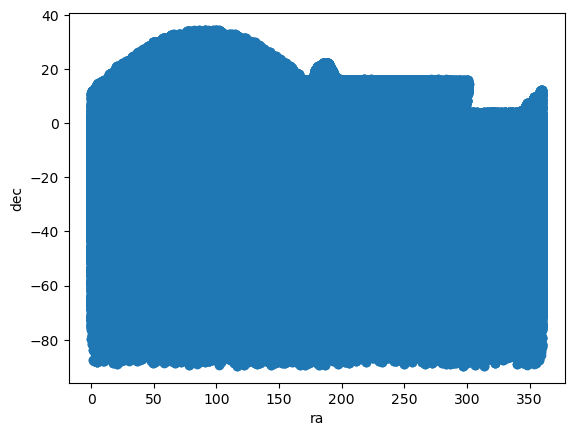

In [129]:
plt.scatter(pointings_database['_ra']*180/np.pi, pointings_database['_dec']*180/np.pi)
plt.xlabel('ra')
plt.ylabel('dec')

In [130]:
survey_fov_sqdeg = 9.6
survey_fov_sqrad = survey_fov_sqdeg*(np.pi/180.0)**2
survey_radius = np.sqrt(survey_fov_sqrad/np.pi)
print('survey_radius:' + str(survey_radius))

survey_radius:0.03050970776212563


In [131]:
parameters = pd.DataFrame(np.array([[0, 1, 2], [0.2813573, 1, 2], [-0.0978646, 1, 2]]).T,
                   columns=['id', 'ra', 'dec'])

parameters_deg = parameters.copy()

parameters['ra'] = parameters_deg['ra'] * np.pi/180
parameters['dec'] = parameters_deg['dec'] * np.pi/180

time_space_overlap, transient_sky_pos_3D, pointings_sky_pos_3D = find_sky_overlaps(pointings_database, parameters)

In [142]:
overlapping_database_iter = pointings_database.iloc[time_space_overlap[0]]
single_filter_single_position = overlapping_database_iter[overlapping_database_iter['filter']=='lsstr']['expMJD']
single_filter_single_position.values


array([60228.01939646, 60229.15751636, 60233.09121907, 60248.13913665,
       60248.1400404 , 60264.06419325, 60285.03369158, 60292.04841646,
       60438.42810582, 60438.43120199, 60442.42964177, 60442.43273505,
       60492.399031  , 60502.37472491, 60531.405594  , 60546.2757241 ,
       60565.18496973, 60565.19173363, 60566.22539358, 60566.22583997,
       60579.15203075, 60579.15474916, 60587.17166363, 60587.17391098,
       60588.14762193, 60607.0919349 , 60607.10323611, 60614.11615829,
       60614.11705594, 60650.05767886, 60810.43036033, 60810.43346189,
       60944.2378171 , 60961.1366425 , 60962.20779987, 60964.1499669 ,
       60993.1732444 , 61243.38915629, 61243.38960408, 61261.39062001,
       61262.29813764, 61265.37217378, 61270.40806052, 61293.27995131,
       61297.20979724, 61298.22341508, 61305.1811942 , 61317.0354486 ,
       61317.07602442, 61323.10967939, 61323.11148749, 61329.1281511 ,
       61329.25398945, 61342.1945769 , 61345.1409437 , 61355.04274181,
      

array([60228.01939646, 60229.15751636, 60233.09121907, 60248.13913665,
       60248.1400404 , 60264.06419325, 60285.03369158, 60292.04841646,
       60438.42810582, 60438.43120199, 60442.42964177, 60442.43273505,
       60492.399031  , 60502.37472491, 60531.405594  , 60546.2757241 ,
       60565.18496973, 60565.19173363, 60566.22539358, 60566.22583997,
       60579.15203075, 60579.15474916, 60587.17166363, 60587.17391098,
       60588.14762193, 60607.0919349 , 60607.10323611, 60614.11615829,
       60614.11705594, 60650.05767886, 60810.43036033, 60810.43346189,
       60944.2378171 , 60961.1366425 , 60962.20779987, 60964.1499669 ,
       60993.1732444 , 61243.38915629, 61243.38960408, 61261.39062001,
       61262.29813764, 61265.37217378, 61270.40806052, 61293.27995131,
       61297.20979724, 61298.22341508, 61305.1811942 , 61317.0354486 ,
       61317.07602442, 61323.10967939, 61323.11148749, 61329.1281511 ,
       61329.25398945, 61342.1945769 , 61345.1409437 , 61355.04274181,
      

# Analysis of real data (Tape Single Pixel)

In [2]:
ens = Ensemble()  # initialize an ensemble object

In [3]:
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46265,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:33424,Total threads: 8
Dashboard: http://127.0.0.1:33251/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:42290,


In [4]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

"""
col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant",
    time_col="mjd_ztf_source",
    flux_col="mag_ztf_source",
    err_col="magerr_ztf_source",
    band_col="band_ztf_source")
"""
col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [11]:
# I am loading all of them individual files just to visualize the distribution
# I want to find the columns that are the same in both object and source catalog
# This is because I want to find a column that I can use as index
test_source_2 = pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17752.parquet")
test_source_3 = pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17753.parquet")
test_source_4= pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17754.parquet")
test_source_5 = pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17755.parquet")
test_object = pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_obj/Norder=5/Dir=0/Npix=4438.parquet")
print()
lst = np.intersect1d(test_object.columns,test_source_2.columns)
lst[:]

array(['DEC_dr16q_constant', 'Dir_dr16q_constant', 'Dir_ps1_otmo',
       'EBV_dr16q_constant', 'FEII_OPT_EW_ERR_dr16q_constant',
       'FEII_OPT_EW_dr16q_constant', 'FEII_UV_EW_ERR_dr16q_constant',
       'FEII_UV_EW_dr16q_constant', 'FIBERID_dr16q_constant',
       'IF_BOSS_SDSS_dr16q_constant', 'LOGL1350_ERR_dr16q_constant',
       'LOGL1350_dr16q_constant', 'LOGL1700_ERR_dr16q_constant',
       'LOGL1700_dr16q_constant', 'LOGL2500_ERR_dr16q_constant',
       'LOGL2500_dr16q_constant', 'LOGL3000_ERR_dr16q_constant',
       'LOGL3000_dr16q_constant', 'LOGL5100_ERR_dr16q_constant',
       'LOGL5100_dr16q_constant', 'LOGLBOL_ERR_dr16q_constant',
       'LOGLBOL_dr16q_constant', 'LOGLEDD_RATIO_ERR_dr16q_constant',
       'LOGLEDD_RATIO_dr16q_constant', 'LOGMBH_CIV_ERR_dr16q_constant',
       'LOGMBH_CIV_dr16q_constant', 'LOGMBH_ERR_dr16q_constant',
       'LOGMBH_HB_ERR_dr16q_constant', 'LOGMBH_HB_dr16q_constant',
       'LOGMBH_MGII_ERR_dr16q_constant', 'LOGMBH_MGII_dr16q_constant',
 

In [7]:
print(len(np.unique(test_source_2.index)), len(np.unique(test_source_3.index)), 
      len(np.unique(test_source_4.index)), len(np.unique(test_source_5.index)))
print(191+189+164+165)
print(len(np.unique(test_object.index)))

191 189 164 165
709
758


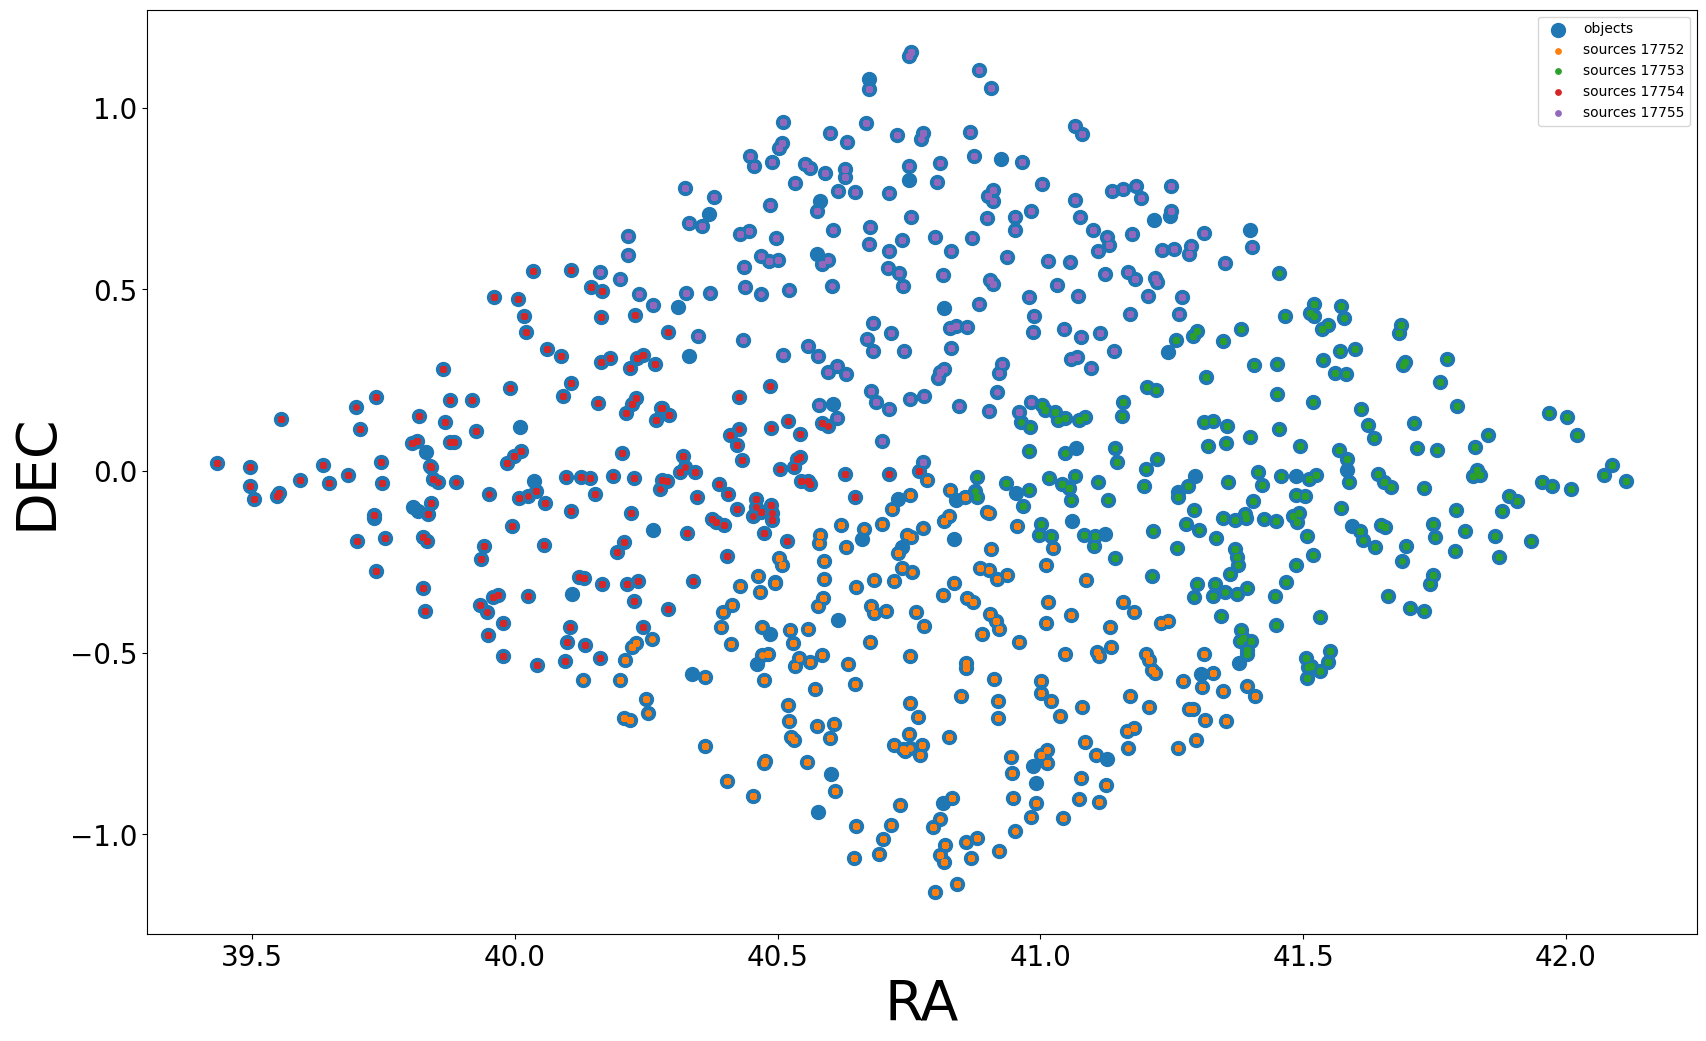

In [9]:
plt.figure(figsize=(20,12))
plt.scatter(test_object['RA_dr16q_constant'].values, test_object['DEC_dr16q_constant'].values, s = 100, label = 'objects')
plt.scatter(test_source_2['RA_dr16q_constant'].values, test_source_2['DEC_dr16q_constant'].values, s = 15, label = 'sources 17752')
plt.scatter(test_source_3['RA_dr16q_constant'].values, test_source_3['DEC_dr16q_constant'].values, s = 15, label = 'sources 17753')
plt.scatter(test_source_4['RA_dr16q_constant'].values, test_source_4['DEC_dr16q_constant'].values, s = 15, label = 'sources 17754')
plt.scatter(test_source_5['RA_dr16q_constant'].values, test_source_5['DEC_dr16q_constant'].values, s = 15, label = 'sources 17755')
plt.xlabel('RA', fontsize=40)
plt.ylabel('DEC', fontsize=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend()

In [8]:
# we inspect object catalog 
ens.head("object")

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,zFlags_ps1_otmo,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,114720,-999.000000,-999.000000,16416,5,0,4438,0.000015,5,0
024321.81-010812.1,4996744985459032064,6782,56572,285,40.840898,-1.136720,6782-56572-0285,BOSS,1.628,VI,...,115000,-999.000000,-999.000000,16416,5,0,4438,0.000010,5,0
024315.98-010433.7,4996747488372195328,4240,55455,202,40.816592,-1.076055,4240-55455-0202,BOSS,1.774,VI,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000017,5,0
024328.22-010352.7,4996749076859977728,6782,56572,298,40.867601,-1.064654,6782-56572-0298,BOSS,1.868,VI,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000005,5,0
024341.05-010243.3,4996749735944519680,4240,55455,178,40.921044,-1.045386,4240-55455-0178,BOSS,2.369,VI,...,115000,19.193501,0.039844,115000,5,0,4438,0.000016,5,0


In [9]:
# we inspect source catalog 
ens.head("source") 

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1


In [10]:
# names of all of the lightcurves that are avaliable
# is this really the best way to get the names of the lightcurves?
ts_index = np.unique(ens._object.index.compute())
ts_index[:5]

array(['023744.13+000118.5', '023759.13-000228.7', '023759.19+000044.2',
       '023800.94-000433.2', '023811.26-000403.4'], dtype=object)

In [11]:
# number of lightcurves
print(len(np.unique(ens._object.index.compute())))
print(len(np.unique(ens._source.index.compute())))

709
709


In [12]:
# are the times in order - they are obviously not in the order
# hm, why does this now work anymore?
"""
single_ts_name = ts_index[5]
ts = ens.to_timeseries('023811.26-000403.4') # provided a target object id
ts.data['mjd_ztf_source']
"""

"\nsingle_ts_name = ts_index[5]\nts = ens.to_timeseries('023811.26-000403.4') # provided a target object id\nts.data['mjd_ztf_source']\n"

In [13]:
ens.query("band_ztf_source == 'g'", table = 'source')

In [14]:
print(len(np.unique(ens._source.compute().index)))
print(len(np.unique(ens._object.compute().index)))
# need refactor ticket to update

603
709


In [15]:
# select only the g band of ztf survey
# ens._source = ens._source[ens._source['band_ztf_source']=='g']
# ens._source.compute()

In [16]:
# at the moment, to hotfix the problem, sort the whole table in time
# but this below does not work....
#ens._source = ens._source.sort_values('mjd_ztf_source')

In [17]:
import importlib
importlib.reload(JaxPeriodDrwFit)

<module 'JaxPeriodDrwFit' from '/astro/users/ncaplar/github/JaxPeriodDrwFit/JaxPeriodDrwFit.py'>

In [18]:
# 6min, 17 sec on baldur, for 603 sources 
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)
# UnfilteredStackTrace: jaxlib.xla_extension.XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: ValueError: Input coordinates must be sorted in order to use the QuasisepSolve

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [19]:
res

SDSS_NAME_dr16q_constant
024048.22-003429.0    [7.0415189839399535, 4.915187749780587, -4.867...
024049.96-004044.9    [2.774598138418049, 4.448066696866833, -3.7067...
024050.36-003109.0    [39.08398224442753, 3.0885003171467984, -0.715...
024052.82-004110.9    [-35.15677216784658, -12.49334964398287, -10.9...
024053.68-002900.7    [34.059112950141994, -0.2890146267372002, -5.6...
                                            ...                        
024507.75+003549.3    [13.040226803724861, -0.04314045114480827, -4....
024508.67+003710.6    [4.380748641637005, 2.1205548111206114, -1.061...
024514.80+003923.3    [20.29904029167756, -14.615262771867126, -5.71...
024524.39+003423.3    [8.111300485561, 0.9674504916644041, -7.685683...
024536.42+003704.2    [35.0508210940623, -15.645026433296477, -6.950...
Name: SDSS_NAME_dr16q_constant, Length: 603, dtype: object

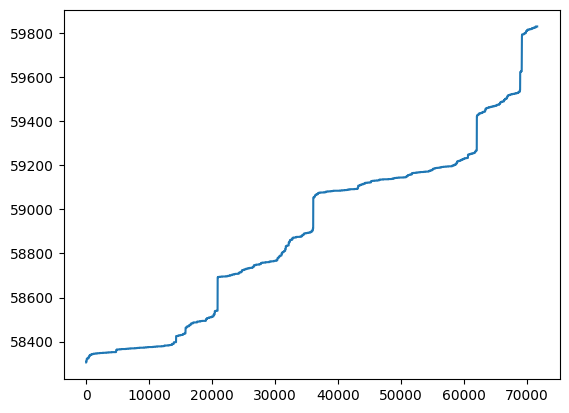

In [42]:
        sorted_indices = np.argsort(t_single)

        # Use these indices to sort y and yerr
        t = t_single.iloc[sorted_indices]
        plt.plot(t.values)

In [43]:
test_single_lc_res = JaxPeriodDrwFit_instance.optimize_map(t_single, y_single, y_err_single,
                                                            n_init=100)

In [44]:
test_single_lc_res

array([ 3.36144996e+05, -5.15595426e+00, -1.41928081e-02,  3.80449048e+00,
       -2.83203920e-01])

In [20]:
ens_it.index[0]

'024311.71-010928.3'